# POS Tagger Trained on the UD Treebank

Adapted from https://github.com/soutsios/pos_tagger_mlp/blob/master/pos_tagger_mlp.ipynb 

# Plot Functions

These functions are useful to visualize the training dynamics of the learning algorithm and the confusion matrix of the trained models.

In [1]:
import pyconll, nltk, datetime, warnings
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [4]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

# Preprocessing

In [5]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [6]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

Print statistics

In [7]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  12544
Tagged words in train set: 204614
Tagged sentences in dev set:  2001
Tagged words in dev set: 25151
Tagged sentences in test set:  2077
Tagged words in test set: 25096


In [8]:
print(train_sentences[0])

[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT')]


In [9]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

An important observation: how many terms are in validation set and not found in train set? (This estimates the Out-of-vocabulary rate.)

In [10]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 1662


# Feature Engineering

We use the "classical" machine learning approach: we will train a token classifier model. The classifier gets as input a feature vector describing each token in the sentence. We decide a priori which features are informative to make the tagging decision. In this case, we use a combination of "word shape" features which approximate morphological knowledge. We naturally also include lexical information (the token form itself), and some form of "syntactic knowledge" by adding reference to the previous and next word in each token feature vector.

In [11]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'word_lower': sentence[index].lower(),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1].lower(),
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1].lower(),
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In the scikit-learn model, we model a dataset as a pair of two data structures:
* The list of feature dictionaries X (one feature dictionary for each token)
* The list of predicted label y (one tag for each token)

In [12]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index)])
            y.append(tagged[index][1])
    return X, y

Given a sentence represented as a list of tokens, return the list of feature dictionaries using our feature encoding method:

In [13]:
def transform_test_sentence(sentence):
    X = []
    for index in range(len(sentence)):
            X.append([features_basic(sentence, index)])
    return X

## Test untag()

We use untag() to extract raw sentences from the annotated CoNLL dataset. This way we can reproduce a sentence without tags, submit it to the tagger and compare predictions to the gold tags that are provided in the dataset.

In [14]:
untag(test_sentences[1])

['What',
 'if',
 'Google',
 'expanded',
 'on',
 'its',
 'search',
 '-',
 'engine',
 '(',
 'and',
 'now',
 'e-mail',
 ')',
 'wares',
 'into',
 'a',
 'full',
 '-',
 'fledged',
 'operating',
 'system',
 '?']

# Dataset Transformation

Before we can apply a generic machine learning algorithm (such as Logistic Regression), we need to encode the dataset into a vectorized format.

We proceed in two steps: feature engineering and vectorization.

For each token, we create a dictionary of features that depend on the sentence from which the token is extracted. 
These features include the word itself, the word before and the word after, letter suffixes and prefixes, etc.

In the scikit-learn approach, before we can use a generic machine learning algorithm, we must then "vectorize" the feature dictionaries into vector encodings.
For example, lexical features are encoded into one-hot vectors whose dimension is the size of the vocabulary.
Note the difference between the method `fit_transform` of the vectorizer, which "learns" how to vectorize features, and `transform` which applies a learned vectorizer to feature dictionaries.  We use `fit_transform` on the training data, and `transform` on the other sections (validation and test).

These vector representations are what is passed to the machine learning algorithm.

In [15]:
def vectorize(train, val, test):

    print('Feature encoding method')
    print('Vectorizing Dataset...')
    print('Vectorizing train...')
    X_train, y_train = transform_to_dataset(train)
    v = DictVectorizer(sparse=True) 
    X_train = v.fit_transform([x[0] for x in X_train])
    
    print('Vectorizing validation...')
    X_val, y_val = transform_to_dataset(val)
    X_val = v.transform([x[0] for x in X_val])        
    
    print('Vectorizing test...')
    X_test, y_test = transform_to_dataset(test)
    X_test = v.transform([x[0] for x in X_test])
    
    print('Dataset vectorized.')
    print('Train shape:', X_train.shape)
    print('Validation shape:', X_val.shape)
    print('Test shape:', X_test.shape)
    
    # Compress sparse matrices
    X_train = X_train 
    X_val = X_val 
    X_test = X_test
    return X_train, y_train, X_val, y_val, X_test, y_test, v
    

# Baseline Tagger

Before we train a "real" machine learning algorithm using scikit-learn, we will repeat the very simple statistical method we discussed in class.
We train and evaluate the Baseline Unigram tagger to compare performance with the tagger we will train next.

In [16]:
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [17]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [18]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [19]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, zero_division=1, average='macro')))

Accuracy: 0.8670
f1-macro score: 0.7959


In [20]:
print(classification_report(y_test, y_pred, zero_division=1, digits=4))

              precision    recall  f1-score   support

         ADJ     0.9154    0.8356    0.8737      1788
         ADP     0.8697    0.8817    0.8757      2029
         ADV     0.9355    0.8044    0.8650      1191
         AUX     0.9233    0.8970    0.9099      1543
       CCONJ     0.9892    0.9973    0.9932       736
         DET     0.9612    0.9673    0.9643      1897
        INTJ     0.9655    0.6942    0.8077       121
        NOUN     0.6878    0.9323    0.7916      4123
         NUM     0.9146    0.6125    0.7337       542
        PART     0.6959    0.9769    0.8128       649
        PRON     0.9660    0.9321    0.9488      2165
       PROPN     0.9240    0.5446    0.6853      2075
       PUNCT     0.9941    0.9861    0.9901      3096
       SCONJ     0.6257    0.5964    0.6107       384
         SYM     0.7913    0.8349    0.8125       109
        VERB     0.8880    0.8243    0.8549      2606
           X     1.0000    0.0000    0.0000        42

    accuracy              

See what errors the Baseline tagger makes:

In [21]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [22]:
check_tagger(test_sentences[1])

('What', 'PRON') PRON 
('if', 'SCONJ') SCONJ 
('Google', 'PROPN') PROPN 
('expanded', 'VERB') VERB 
('on', 'ADP') ADP 
('its', 'PRON') PRON 
('search', 'NOUN') NOUN 
('-', 'PUNCT') PUNCT 
('engine', 'NOUN') NOUN 
('(', 'PUNCT') PUNCT 
('and', 'CCONJ') CCONJ 
('now', 'ADV') ADV 
('e-mail', 'NOUN') NOUN 
(')', 'PUNCT') PUNCT 
('wares', 'NOUN') NOUN 
('into', 'ADP') ADP 
('a', 'DET') DET 
('full', 'ADJ') ADV <<--- Error!
('-', 'PUNCT') PUNCT 
('fledged', 'NOUN') ADJ <<--- Error!
('operating', 'NOUN') NOUN 
('system', 'NOUN') NOUN 
('?', 'PUNCT') PUNCT 


It makes mistakes. Unsurprising given its simplistic approach and the small size of the training data.

In [23]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

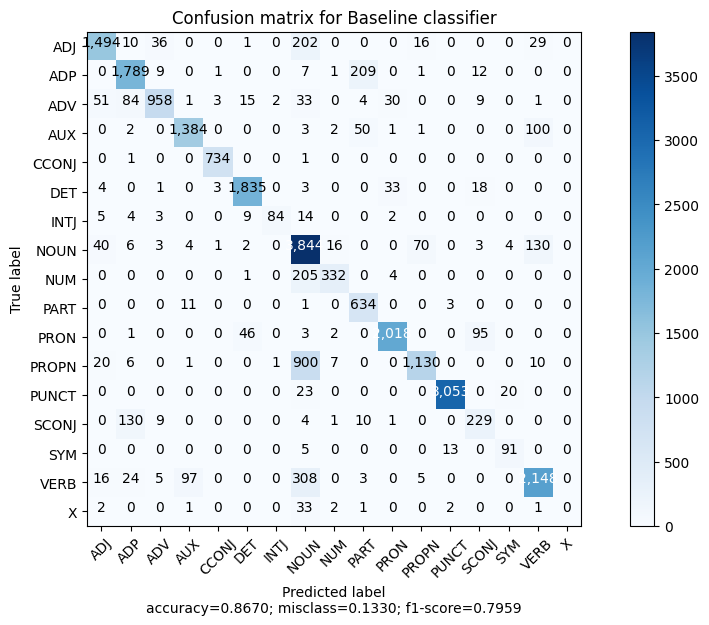

In [24]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a Logistic Regression Model

Let us move to a more serious machine learning model. We will train a Logistic Regression model using our feature extraction function based on our "expertise" in the domain.

We first transform the whole dataset from the CoNLL format into the scikit-learn vectorized encoding using our feature extraction method.

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences)

Feature encoding method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (204614, 98719)
Validation shape: (25151, 98719)
Test shape: (25096, 98719)


## Hyper-parameter Tuning

The Logistic Regression algorithm uses a hyper-parameter called C.  We tune the value of this parameter by testing different values on a subset of the training data and observing the impact of the C parameter on selected metrics (accuracy and F1).

Because we will use cross-validation, we can use the full train set (train + validation)

In [26]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [27]:
X_train.shape

(229765, 98719)

In [28]:
y_train.shape

(229765,)

In [29]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [30]:
logregr = LogisticRegression(solver='liblinear', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=4)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=4)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(random_state=13, solver='liblinear')
# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 20}

Grid scores on development set:
0.748 (+/-0.027) for {'C': 0.1}
0.828 (+/-0.046) for {'C': 1}
0.834 (+/-0.041) for {'C': 2}
0.836 (+/-0.035) for {'C': 3}
0.836 (+/-0.035) for {'C': 4}
0.838 (+/-0.029) for {'C': 5}
0.842 (+/-0.033) for {'C': 10}
0.846 (+/-0.035) for {'C': 20}
0.844 (+/-0.042) for {'C': 50}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.0000    0.0000    0.0000         1
         ADP     1.0000    0.6667    0.8000         6
         ADV     0.0000    0.0000    0.0000         4
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    0.5000    0.6667         2
         DET     0.6667    1.0000    0.8000         2
        NOUN  

## Training

We can now training using the best hyper-parameter selected above.  This takes a few minutes.

In [31]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Training...
Training completed in 245.305009 seconds


# Evaluation

In [32]:
y_pred = clf.predict(X_test)

In [33]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.9451
f1-macro score: 0.9023


## Classification Report

In [34]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

         ADJ     0.9206    0.9010    0.9107      1788
         ADP     0.9342    0.9591    0.9465      2029
         ADV     0.9225    0.8900    0.9060      1191
         AUX     0.9787    0.9825    0.9806      1543
       CCONJ     0.9946    0.9932    0.9939       736
         DET     0.9915    0.9895    0.9905      1897
        INTJ     0.9619    0.8347    0.8938       121
        NOUN     0.9044    0.9202    0.9122      4123
         NUM     0.9743    0.9797    0.9770       542
        PART     0.9799    0.9769    0.9784       649
        PRON     0.9853    0.9880    0.9866      2165
       PROPN     0.8817    0.8617    0.8716      2075
       PUNCT     0.9916    0.9958    0.9937      3096
       SCONJ     0.8567    0.8099    0.8327       384
         SYM     0.8476    0.8165    0.8318       109
        VERB     0.9440    0.9574    0.9507      2606
           X     0.5000    0.3095    0.3824        42

    accuracy              

## Frequent Types of Mistakes

In [35]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9451
Total errors/Total words: 1377/25096

Most common errors: [('that', 24), ('as', 23), ('to', 23), ('like', 22), ('/', 21), ('out', 18), ('for', 18), ('up', 18), ('in', 16), ('on', 12), ('01-Feb-02', 11), ('one', 9), ('-', 9), ('so', 8), ('much', 8), ('all', 7), ('have', 7), ('be', 7), ('of', 6), ('better', 6)]


## Learning Curves

The following diagram illustrates the "training dynamics" of the LR model: how fast does it improve as it keeps training. Originally, the difference between the test dataset and the cross-validation (on part of the test data) is large; as training proceeds, the gap reduces. This diagram is important to verify we do not have a case of over-fitting - where the model does "very well" on training data and does not improve on test data.  

This computation takes a long time (as we keep training and evaluating multiple times to obtain the snapshots). It is not necessary to run the rest of the notebook so that you can safely skip it.

In [ ]:
plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5)

## Confusion Matrix

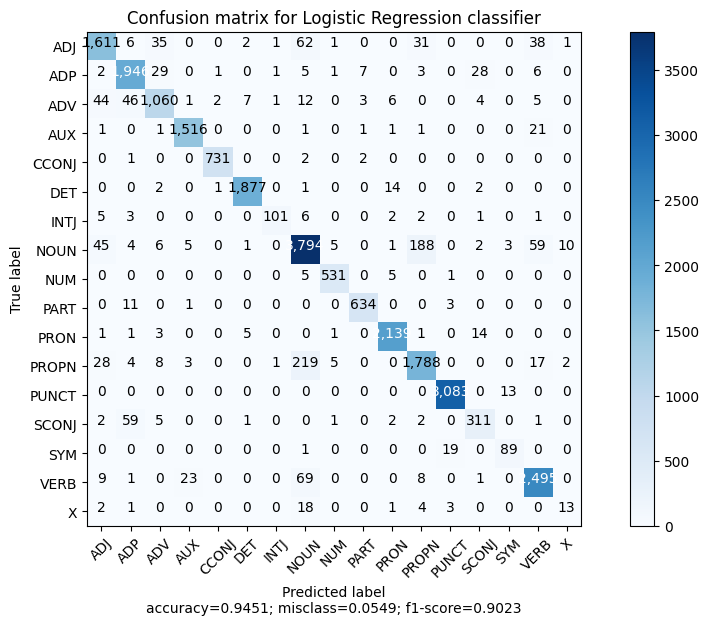

In [36]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an Unknown Sentence

Lets try our trained tagger on new sentences.  To tag a sentence given as a string, we must apply the following steps:
* Tokenize the string into a list of tokens
* Turn each token into a features dictionary (using the features used by our model)
* Turn the list of feature dictionaries into vectors (using scikit-learn vectorization method)
* Pass the resulting matrix (one row vector for each token) to the classifier.

In [37]:
# Need to download the nltk model for sentence tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\97252\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [38]:
tokens = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.')
print(tokens)

['Word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']


In [39]:
X_features = transform_test_sentence(tokens)

In [40]:
X_features

[[{'nb_terms': 13,
   'word': 'Word',
   'word_lower': 'word',
   'is_first': True,
   'is_last': False,
   'is_capitalized': True,
   'is_all_caps': False,
   'is_all_lower': False,
   'prefix-1': 'W',
   'prefix-2': 'Wo',
   'prefix-3': 'Wor',
   'suffix-1': 'd',
   'suffix-2': 'rd',
   'suffix-3': 'ord',
   'i-1_prefix-3': '',
   'i-1_suffix-3': '',
   'i+1_prefix-3': 'emb',
   'i+1_suffix-3': 'ngs',
   'prev_word': '',
   'next_word': 'embeddings',
   'has_hyphen': False,
   'is_numeric': False,
   'capitals_inside': False}],
 [{'nb_terms': 13,
   'word': 'embeddings',
   'word_lower': 'embeddings',
   'is_first': False,
   'is_last': False,
   'is_capitalized': False,
   'is_all_caps': False,
   'is_all_lower': True,
   'prefix-1': 'e',
   'prefix-2': 'em',
   'prefix-3': 'emb',
   'suffix-1': 's',
   'suffix-2': 'gs',
   'suffix-3': 'ngs',
   'i-1_prefix-3': 'Wor',
   'i-1_suffix-3': 'ord',
   'i+1_prefix-3': 'pro',
   'i+1_suffix-3': 'ide',
   'prev_word': 'word',
   'next_word'

In [41]:
X_vectorized = vec.transform([x[0] for x in X_features])

In [42]:
# The vectorized sentence is a sparse matrix with one row for each token and columns for the vectorized features
# For example, if the vocabulary has 1000 unique words, the vectorized sentence will have 1000 columns for each word feature.
# This is a very sparse matrix, where most of the values are zero.
X_vectorized.shape

(13, 98719)

In [43]:
pred = clf.predict(X_vectorized)

In [44]:
# np.str_ is a subclass of str that is used to represent string arrays in NumPy.
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(tokens, pred)))

Here is what our LR tagger predicts for the test sentence:
 [('Word', np.str_('PROPN')), ('embeddings', np.str_('NOUN')), ('provide', np.str_('VERB')), ('a', np.str_('DET')), ('dense', np.str_('ADJ')), ('representation', np.str_('NOUN')), ('of', np.str_('ADP')), ('words', np.str_('NOUN')), ('and', np.str_('CCONJ')), ('their', np.str_('PRON')), ('relative', np.str_('ADJ')), ('meanings', np.str_('NOUN')), ('.', np.str_('PUNCT'))]


Let's turn this process into a prediction function from a sentence encoded as a single string to a list of pairs (token, predicted_tag):

In [45]:
def predict_sentence(sentence):
   tokens = nltk.word_tokenize(sentence)
   X_features = transform_test_sentence(tokens)
   X_vectorized = vec.transform([x[0] for x in X_features])
   pred = clf.predict(X_vectorized)
   return list(zip(tokens, pred))

In [46]:
predict_sentence("Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.")

[('Let', np.str_('VERB')),
 ('me', np.str_('PRON')),
 ('join', np.str_('VERB')),
 ('the', np.str_('DET')),
 ('chorus', np.str_('NOUN')),
 ('of', np.str_('ADP')),
 ('annoyance', np.str_('NOUN')),
 ('over', np.str_('ADP')),
 ('Google', np.str_('PROPN')),
 ("'s", np.str_('PART')),
 ('new', np.str_('ADJ')),
 ('toolbar', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('which', np.str_('PRON')),
 (',', np.str_('PUNCT')),
 ('as', np.str_('SCONJ')),
 ('noted', np.str_('VERB')),
 ('in', np.str_('ADP')),
 ('the', np.str_('DET')),
 ('linked', np.str_('VERB')),
 ('article', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('commits', np.str_('NOUN')),
 ('just', np.str_('ADV')),
 ('about', np.str_('ADV')),
 ('every', np.str_('DET')),
 ('sin', np.str_('VERB')),
 ('an', np.str_('DET')),
 ('online', np.str_('ADJ')),
 ('marketer', np.str_('NOUN')),
 ('could', np.str_('AUX')),
 ('commit', np.str_('VERB')),
 (',', np.str_('PUNCT')),
 ('and', np.str_('CCONJ')),
 ('makes', np.str_('VERB')),
 ('up', np.str_('ADP'

# Collect Hard Sentences

Hard sentences are sentences that contain multiple wrongly predicted tags given our classifier.

Write code to collect hard sentences given a classifier clf.

In [47]:
def errors_in_sentence_prediction(clf, tagged_sentence):
    """Given a tagged sentence from the dataset, return the number of errors and the predicted tags."""
    errors = 0
    tokens = [word for word, _ in tagged_sentence] 
    true_tags = [true_tag for _, true_tag in tagged_sentence] 

    X_features = transform_test_sentence(tokens)
    X_vectorized = vec.transform([x[0] for x in X_features])
    pred = clf.predict(X_vectorized)

    for i in range(len(tokens)):
        if true_tags[i] != pred[i]:
            errors += 1

    return errors, pred

In [48]:
hard_sentences = []
idx = 0
for s in test_sentences:
    errors, pred = errors_in_sentence_prediction(clf, s)
    if errors > 0:
        hard_sentences.append((s, errors, pred, idx))
    idx += 1
print(f'Number of sentences with errors: {len(hard_sentences)} out of {len(test_sentences)}')

Number of sentences with errors: 802 out of 2077


Draw a histogram showing how the sentences in the test dataset are distributed in terms of prediction errors per sentence.

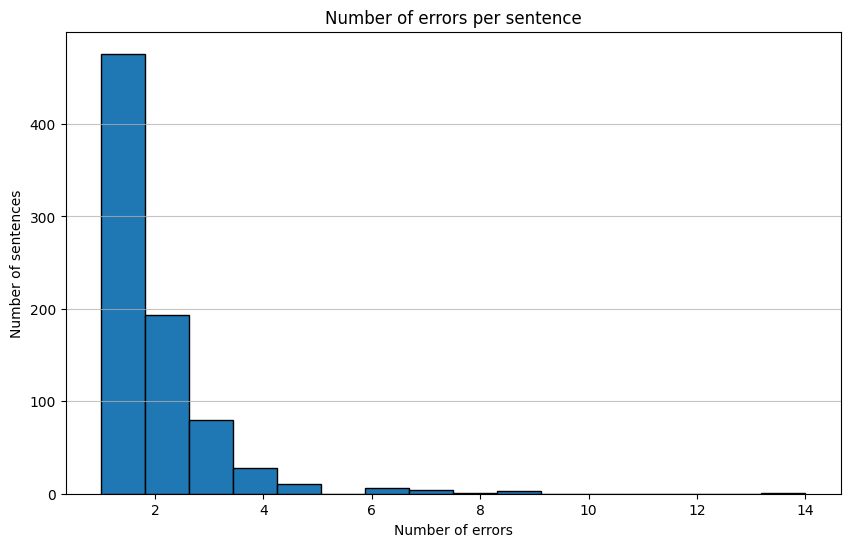

In [49]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [50]:
# Show prediction errors for sentences with more than 5 errors.
for s in hard_sentences:
    if s[1] > 5:
        print(" ".join(untag(s[0])))
        print('Number of errors:', s[1])
        for i in range(len(s[0])):
            if s[0][i][1] != s[2][i]:
                print(f'{s[0][i][0]:<20}  C: {s[0][i][1]:<12}  P: {s[2][i]:<12} **** Error')
            else:
                print(f'{s[0][i][0]:<23}  {s[0][i][1]:<12}')
        print(40*'=')


Stay with me now : John Paul STEVENS delivered the opinion of the Court with respect to Parts I through IV , VI through VI - D - iii , VI - D - v , and VII , in which KENNEDY , SOUTER , GINSBURG , and BREYER joined , and an opinion with respect to Parts V and VI - D - iv , in which SOUTER , GINSBURG , and BREYER joined .
Number of errors: 8
Stay                     VERB        
with                     ADP         
me                       PRON        
now                      ADV         
:                        PUNCT       
John                     PROPN       
Paul                     PROPN       
STEVENS               C: PROPN         P: NOUN         **** Error
delivered                VERB        
the                      DET         
opinion                  NOUN        
of                       ADP         
the                      DET         
Court                    NOUN        
with                     ADP         
respect                  NOUN        
to                   

## Error Analysis

1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).
2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.
3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.


In [51]:
tokens = collections.defaultdict(list)
sen_ids = [] 
for i, s in enumerate(hard_sentences):
    words = [word for word, _ in hard_sentences[i][0]]
    full_s = ' '.join(words)
    sen_ids.append(full_s)
    for j in range(len(s[0])):
        if s[0][j][1] != s[2][j]:
            tokens[s[0][j][0]].append(i)

sentences = set()
print("Tokens with more than 10 errors:")
for token, lst in tokens.items():
    if len(lst) > 10:
        print(token)
        for index in lst:
            sentences.add(sen_ids[index])

print("Total amount of sentences:", len(sentences))

print("Sentences where the errors are predicted:\n")
for s in sentences:
    print(s)

Tokens with more than 10 errors:
out
on
as
to
/
that
for
up
like
in
01-Feb-02
Total amount of sentences: 179
Sentences where the errors are predicted:

John Donovan from Argghhh! has put out a excellent slide show on what was actually found and fought for in Fallujah .
The thing about The Script is they do not sound that Irish , I was surprised to hear they were from Dublin .
" We are so excited that the White House and the recent new government space policy underscores the need to involve the private sector in assisting NASA develop its plans for the new Vision for Space Exploration , " said Walter Kistler , LTS co-founder and Chairman .
Looks like the kids had a great time !
ALITO filed a dissenting opinion , in which SCALIA and THOMAS joined as to Parts I through III .
There may or may not be snow , depending on local weather conditions .
This morning 's paper reports that a rate increase of 40 % may be imposed by the CDWR as early as today and the new bond issue amount is purported

## 2.1


In [52]:
# --- Imports ---
import os
from openai import OpenAI
from pydantic import BaseModel, Field
from enum import Enum
from typing import List, Optional
import time

# 
model = 'grok-3-mini'

In [53]:
# --- Define the Universal Dependencies POS Tagset (17 core tags) as an enum ---
class UDPosTag(str, Enum):
    ADJ = "ADJ"     # adjective
    ADP = "ADP"     # adposition
    ADV = "ADV"     # adverb
    AUX = "AUX"     # auxiliary verb
    CCONJ = "CCONJ" # coordinating conjunction
    DET = "DET"     # determiner
    INTJ = "INTJ"   # interjection
    NOUN = "NOUN"   # noun
    NUM = "NUM"     # numeral
    PART = "PART"   # particle
    PRON = "PRON"   # pronoun
    PROPN = "PROPN" # proper noun
    PUNCT = "PUNCT" # punctuation
    SCONJ = "SCONJ" # subordinating conjunction
    SYM = "SYM"     # symbol
    VERB = "VERB"   # verb
    X = "X"         # other / unknown


In [54]:
# TODO Define more Pydantic models for structured output
class TokenPOS(BaseModel):
    text: str = Field(description="The token text")
    pos_tag: UDPosTag = Field(description="The Universal Dependencies POS tag")

class SentencePOS(BaseModel):
    tokens: List[TokenPOS] = Field(description="List of tokens with their POS tags")

class TaggedSentences(BaseModel):
    """Represents a list of sentences with their tagged tokens."""
    sentences: List[SentencePOS] = Field(description="A list of sentences, each containing tagged tokens.")

# --- Configure the Grok API ---
# Get a key https://console.x.ai/team 
# Use os.environ.get for production environments.
# For Colab/AI Studio, you might use userdata.get
# Example:
# from google.colab import userdata
# GROK_API_KEY = userdata.get('GROK_API_KEY')
# genai.configure(api_key=GROK_API_KEY)

# Make sure to replace "YOUR_API_KEY" with your actual key if running locally
# and not using environment variables or userdata.
try:
    # Attempt to get API key from environment variable
    def load_env_from_ini(filename):
        with open(filename) as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                key, value = line.split('=', 1)
                os.environ[key.strip()] = value.strip()

    # Load the API key
    load_env_from_ini("grok_key.ini")
    api_key = os.environ.get("GROK_API_KEY")
    if not api_key:
        # Fallback or specific instruction for local setup
        # Replace with your actual key if needed, but environment variables are safer
        api_key = "YOUR_API_KEY"
        if api_key == "YOUR_API_KEY":
           print("⚠️ Warning: API key not found in environment variables. Using placeholder.")
           print("   Please set the GROK_API_KEY environment variable or replace 'YOUR_API_KEY' in the code.")

    client = OpenAI(
        api_key=api_key,
        base_url="https://api.x.ai/v1",
    )

except Exception as e:
    print(f"Error configuring API: {e}")
    print("Please ensure you have a valid API key set.")
    # Depending on the environment, you might want to exit here
    # import sys
    # sys.exit(1)



In [55]:
def tag_sentences_ud(text_to_tag: str) -> Optional[TaggedSentences]:
    """
    Performs POS tagging on the input list of sentences using the Grok API and
    returns the result structured according to the TaggedSentences Pydantic model.

    Args:
        text_to_tag: The sentence or text to be tagged.

    Returns:
        A SentencePOS object containing the tagged tokens, or None if an error occurs.
    """
    # Construct the prompt
    prompt = f"""You are a specialized Universal Dependencies POS tagger that outputs precise structured JSON.
            Tag each token with Universal Dependencies (UD) POS tags: 
            Tags: 
            ADJ=adjective, ADP=adposition, ADV=adverb, AUX=auxiliary, CCONJ=coordinating conjunction, DET=determiner, INTJ=interjection, NOUN=noun, NUM=numeral, PART=particle, PRON=pronoun, PROPN=proper noun, PUNCT=punctuation, SCONJ=subordinating conjunction, SYM=symbol, VERB=verb, X=other 
            Rules: 
            - Split contractions: "don't" → "do"[AUX] + "n't"[PART] 
            - Split hyphens: "search-engine" → "search"[NOUN] + "-"[PUNCT] + "engine"[NOUN] 
            - Separate punctuation: "(hello)" → "("[PUNCT] + "hello"[NOUN] + ")"[PUNCT] 
            - Proper nouns: Capitalize specific entities: "Google"[PROPN] vs "search"[NOUN] 
            - Numbers: Both "2"[NUM] and "two"[NUM]
            Sentences to tag:
            {text_to_tag}
    """

    completion = client.beta.chat.completions.parse(
        model="grok-3",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": text_to_tag},
        ],
        response_format=TaggedSentences,
    )
    # print(completion)
    res = completion.choices[0].message.parsed
    return res


In [56]:

from ratelimit import limits, sleep_and_retry
import concurrent.futures
from typing import List, Optional

# Define rate-limited API call function
@sleep_and_retry
@limits(calls=5, period=1)  # 5 calls per second
def rate_limited_tag(text_to_tag: str) -> Optional[TaggedSentences]:
    return tag_sentences_ud(text_to_tag)

def batch_tag_sentences_ud(sentences: List[str], batch_size: int = 15) -> List[TaggedSentences]:
    """Process sentences in parallel with rate limiting"""
    # Create batches
    batches = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        batch_text = "\n\n".join(batch)
        batches.append(batch_text)
    
    print(f"Processing {len(batches)} batches with parallel workers...")
    results = [None] * len(batches)
    
    # Use ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Submit all tasks to the executor
        future_to_batch = {executor.submit(rate_limited_tag, batch): i 
                          for i, batch in enumerate(batches)}
        
        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_batch):
            batch_idx = future_to_batch[future]
            try:
                result = future.result()
                if result:
                    results[batch_idx] = result
                    print(f"✓ Completed batch {batch_idx+1}/{len(batches)}")
                else:
                    print(f"✗ Failed batch {batch_idx+1}/{len(batches)}")
            except Exception as e:
                print(f"✗ Error processing batch {batch_idx+1}: {e}")
    
    return results


In [57]:
# --- Example Usage ---
if __name__ == "__main__":
    # example_text = "The quick brown fox jumps over the lazy dog."
    example_text = """
    What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?
    Google Search is a web search engine developed by Google LLC.
    It does n't change the company 's intrinsic worth , and as the article notes , the company might be added to a major index once the shares get more liquid .
    I 've been looking at the bose sound dock 10 i ve currently got a jvc mini hifi system , i was wondering what would be a good set of speakers .
    which is the best burger chain in the chicago metro area like for example burger king portillo s white castle which one do you like the best ?
    """
    # example_text = "החתול המהיר קופץ מעל הכלב העצלן." # Example in Hebrew

    print(f"\nTagging text: \"{example_text}\"")

    tagged_result = tag_sentences_ud(example_text)

    if tagged_result:
        print("\n--- Tagging Results ---")
        for s in tagged_result.sentences:
            # TODO: Retrieve tokens and tags from each sentence:
            for token in s.tokens:
                tag = token.pos_tag
                token = token.text
                # Handle potential None for pos_tag if model couldn't assign one
                ctag = tag if tag is not None else "UNKNOWN"
                print(f"Token: {token:<15} {str(ctag)}")
                print("----------------------")
    else:
        print("\nFailed to get POS tagging results.")


Tagging text: "
    What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?
    Google Search is a web search engine developed by Google LLC.
    It does n't change the company 's intrinsic worth , and as the article notes , the company might be added to a major index once the shares get more liquid .
    I 've been looking at the bose sound dock 10 i ve currently got a jvc mini hifi system , i was wondering what would be a good set of speakers .
    which is the best burger chain in the chicago metro area like for example burger king portillo s white castle which one do you like the best ?
    "

--- Tagging Results ---
Token: What            UDPosTag.PRON
----------------------
Token: if              UDPosTag.SCONJ
----------------------
Token: Google          UDPosTag.PROPN
----------------------
Token: expanded        UDPosTag.VERB
----------------------
Token: on              UDPosTag.ADP
----------------------
Token: its         

In [58]:

lr_hard_sentences = [s for s in hard_sentences if 1 <= s[1] <= 3]
sentences = [" ".join(word for word, _ in pairs) for pairs, _, _ , _ in lr_hard_sentences]
results_llm = batch_tag_sentences_ud(sentences, batch_size=15)


Processing 50 batches with parallel workers...
✓ Completed batch 10/50
✓ Completed batch 9/50
✓ Completed batch 8/50
✓ Completed batch 7/50
✓ Completed batch 1/50
✓ Completed batch 3/50
✓ Completed batch 11/50
✓ Completed batch 12/50
✓ Completed batch 2/50
✓ Completed batch 6/50
✓ Completed batch 13/50
✓ Completed batch 4/50
✓ Completed batch 5/50
✓ Completed batch 14/50
✓ Completed batch 18/50
✓ Completed batch 16/50
✓ Completed batch 19/50
✓ Completed batch 15/50
✓ Completed batch 22/50
✓ Completed batch 17/50
✓ Completed batch 26/50
✓ Completed batch 21/50
✓ Completed batch 20/50
✓ Completed batch 27/50
✓ Completed batch 29/50
✓ Completed batch 23/50
✓ Completed batch 28/50
✓ Completed batch 31/50
✓ Completed batch 30/50
✓ Completed batch 25/50
✓ Completed batch 32/50
✓ Completed batch 33/50
✓ Completed batch 24/50
✓ Completed batch 35/50
✓ Completed batch 40/50
✓ Completed batch 36/50
✓ Completed batch 34/50
✓ Completed batch 42/50
✓ Completed batch 39/50
✓ Completed batch 41/50
✓ 

In [61]:
llm_pred = [[token.pos_tag for token in sentence.tokens] for result in results_llm for sentence in result.sentences]
llm_tokens = [[token.text for token in sentence.tokens] for result in results_llm for sentence in result.sentences]

print((word for word, _ in pairs) for pairs, _ in lr_hard_sentences[4])
print([word for word in llm_tokens[4]])
print(test_sentences[lr_hard_sentences[4][3]])

<generator object <genexpr> at 0x000001F38B42A260>
['I', 'doubt', 'the', 'very', 'few', 'who', 'actually', 'read', 'my', 'blog', 'have', 'not', 'come', 'across', 'this', 'yet', ',', 'but', 'I', 'figured', 'I', 'would', 'put', 'it', 'out', 'there', 'anyways', '.']
[('I', 'PRON'), ('doubt', 'VERB'), ('the', 'DET'), ('very', 'ADV'), ('few', 'ADJ'), ('who', 'PRON'), ('actually', 'ADV'), ('read', 'VERB'), ('my', 'PRON'), ('blog', 'NOUN'), ('have', 'AUX'), ('not', 'PART'), ('come', 'VERB'), ('across', 'ADP'), ('this', 'PRON'), ('yet', 'ADV'), (',', 'PUNCT'), ('but', 'CCONJ'), ('I', 'PRON'), ('figured', 'VERB'), ('I', 'PRON'), ('would', 'AUX'), ('put', 'VERB'), ('it', 'PRON'), ('out', 'ADV'), ('there', 'ADV'), ('anyways', 'ADV'), ('.', 'PUNCT')]


In [67]:
llm_pred = [[token.pos_tag for token in sentence.tokens] for result in results_llm for sentence in result.sentences]
llm_words = [[token.text for token in sentence.tokens] for result in results_llm for sentence in result.sentences]
fixed_by_llm = 0
new_errors_by_llm = 0
llm_hard_sentences = []
llm_error_data = []
mismatches = 0

for i, (s, errors, lr_tags, idx) in enumerate(lr_hard_sentences):
    words = [word for word, _ in s]
    true_tags = [true_tag for _, true_tag in s]
    if i >= len(llm_pred):
        print(f"Skipping sentence {i} due to index out of range.")
        continue
    pred_tags = llm_pred[i]
    

    # Sanity check: length of tokens should match
    if len(true_tags) != len(pred_tags) or len(pred_tags) != len(words):
        print(f"Length mismatch in sentence {i}: true={len(true_tags)}, pred={len(pred_tags)}")
        print(llm_words[i])
        print(words)
        mismatches += 1
        continue

    llm_errors = 0
    for j in range(len(words)):
        if true_tags[j] != pred_tags[j]:
            llm_errors += 1
            llm_error_data.append((words[j], true_tags[j], pred_tags[j]))
        lr_wrong = lr_tags[j] != true_tags[j]
        llm_wrong = pred_tags[j] != true_tags[j]
        
        if lr_wrong and not llm_wrong:
            fixed_by_llm += 1
        if not lr_wrong and llm_wrong:
            new_errors_by_llm += 1
            
    if llm_errors > 0:
        llm_hard_sentences.append((s, llm_errors))

print(f'Number of sentences with errors (llm): {len(llm_hard_sentences)} out of {len(lr_hard_sentences)}')
print(f'Number of sentences with errors (lr): {len(lr_hard_sentences)}')
print(f"✅ Errors fixed by LLM: {fixed_by_llm}")
print(f"⚠️  New errors made by LLM: {new_errors_by_llm}")
print(f"❗️ Mismatches in sentence length: {mismatches}")

Length mismatch in sentence 5: true=22, pred=23
['John', 'Donovan', 'from', 'Argghhh', '!', 'has', 'put', 'out', 'a', 'excellent', 'slide', 'show', 'on', 'what', 'was', 'actually', 'found', 'and', 'fought', 'for', 'in', 'Fallujah', '.']
['John', 'Donovan', 'from', 'Argghhh!', 'has', 'put', 'out', 'a', 'excellent', 'slide', 'show', 'on', 'what', 'was', 'actually', 'found', 'and', 'fought', 'for', 'in', 'Fallujah', '.']
Length mismatch in sentence 15: true=33, pred=36
['Angry', 'crowds', 'chanted', 'anti', '-', 'American', 'slogans', 'in', 'the', 'western', 'city', 'of', 'Falluja', '(', 'pop', '.', '256,000', ')', 'as', 'the', 'security', 'police', 'killed', 'in', 'a', 'friendly', 'fire', 'incident', 'by', 'US', 'troops', 'were', 'buried', 'on', 'Saturday', '.']
['Angry', 'crowds', 'chanted', 'anti-American', 'slogans', 'in', 'the', 'western', 'city', 'of', 'Falluja', '(', 'pop.', '256,000', ')', 'as', 'the', 'security', 'police', 'killed', 'in', 'a', 'friendly', 'fire', 'incident', 'by'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  

# Plot the histogram for LR
ax[0].hist([x[1] for x in lr_hard_sentences], bins=range(1, 6), edgecolor='black', rwidth=0.8)
ax[0].set_title("LR Tagger Error Histogram")
ax[0].set_xlabel("Number of Errors")
ax[0].set_ylabel("Number of Sentences")
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))

# Plot the histogram for LLM
ax[1].hist([errors for s, errors in llm_hard_sentences], bins=range(1, 6), edgecolor='black', rwidth=0.8)
ax[1].set_title("LLM Tagger Error Histogram")
ax[1].set_xlabel("Number of Errors")
ax[1].set_ylabel("Number of Sentences")
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


## 2.3

In [ ]:
from typing import List, Tuple, Dict
from pydantic import BaseModel

class ErrorExplanation(BaseModel):
    word: str
    correct_tag: str
    predicted_tag: str
    explanation: str
    category: str   

def explain_tagging_errors(
    errors: List[Tuple[str, str, "UDPosTag"]],
    sentence_context: str = "The error word appeared in a sentence. You may assume typical usage.",
    max_errors: int = 20,
    delay: float = 1.0
) -> List[Dict]:
    """
    Uses Grok to explain POS tagging errors.

    Args:
        errors: A list of (word, predicted_tag, correct_tag) tuples.
        sentence_context: Optional sentence to help Grok understand usage.
        max_errors: Maximum number of errors to process.
        delay: Seconds to wait between requests.

    Returns:
        A list of dictionaries with keys: word, correct_tag, predicted_tag, explanation, category.
    """
    explanations = []

    for word, predicted_tag, correct_tag in errors[:max_errors]:
        prompt = f"""
    You are a linguistics expert.

    A POS tagging model made the following error:
    - Word: {word}
    - Correct tag: {correct_tag.value}
    - Predicted tag: {predicted_tag}
    - Sentence context: {sentence_context}

    Explain in 1–3 sentences why this tagging error likely occurred, using a clear linguistic explanation (e.g., idiom, function word, capitalization confusion, named entity confusion, etc.).

    Then provide a **concise category** that captures the main cause of the error.
    ⚠️ The category must be **one of the following** (choose the best match):

    - Function word misclassification
    - Capitalization
    - Named entity issue
    - Punctuation influence
    - Contextual ambiguity
    - Preposition/Adverb confusion
    - Model bias
    - Idiomatic expression
    - Word frequency bias
    - Tokenization mismatch

    Do **not** create new category names. Only pick from the list above.

    Return a JSON object with:
    - word
    - correct_tag
    - predicted_tag
    - explanation
    - category
    """

        try:
            completion = client.beta.chat.completions.parse(
                model="grok-3",
                messages=[
                    {"role": "system", "content": prompt}
                ],
                response_format=ErrorExplanation,
            )
            parsed: ErrorExplanation = completion.choices[0].message.parsed
            explanations.append(parsed.dict())  # Convert to plain dict
            time.sleep(delay)
        except Exception as e:
            print(f"Error explaining word '{word}': {e}")
            continue

    return explanations

In [ ]:
import json


def format_explanations_as_json_block(explanations: list) -> str:
    formatted = []

    for e in explanations:
        word = e["word"].upper()
        correct = e["correct_tag"]
        predicted = e["predicted_tag"]

        # Try to extract short category + tag pair
        if "/" in e["category"]:
            parts = e["category"].split("/")
            if len(parts) == 2:
                tag1, tag2 = parts[0].strip(), parts[1].split()[0].strip()  # split off 'ambiguity'
                category = f"Ambiguity ({tag1}/{tag2})"
            elif len(parts) == 3:  # e.g. "ADP/ADV ambiguity"
                tag1, tag2 = parts[0].strip(), parts[1].strip()
                category = f"Ambiguity ({tag1}/{tag2})"
            else:
                category = e["category"].capitalize()
        else:
            category = e["category"].capitalize()

        formatted.append({
            "word": word,
            "correct_tag": correct,
            "predicted_tag": predicted,
            "explanation": e["explanation"].strip(),
            "category": category
        })

    return "JSON\n" + json.dumps(formatted, indent=2)


In [ ]:
explanations = explain_tagging_errors(llm_error_data[0:20])
print(format_explanations_as_json_block(explanations))


In [ ]:
from collections import Counter

category_counter = Counter([e["category"] for e in explanations])

import matplotlib.pyplot as plt

# Sort categories by frequency
sorted_items = sorted(category_counter.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_items)

plt.figure(figsize=(10, 6))
plt.barh(categories, counts, color='skyblue', edgecolor='black')
plt.xlabel("Number of Errors")
plt.title("Error Categories in LLM Tagging")
plt.gca().invert_yaxis()  # Largest on top
plt.tight_layout()
plt.show()

for cat, count in category_counter.most_common():
    print(f"{cat}: {count}")


In [ ]:
import time
import random
import json
from typing import List
from pydantic import BaseModel, RootModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from grok import client
from tqdm import tqdm

# ✅ Define schemas
class SyntheticSentence(BaseModel):
    sentence: List[str]
    tags: List[str]

class SyntheticBatch(RootModel[List[SyntheticSentence]]):
    pass

# ✅ Predefined error categories
error_categories = [
    "Function word misclassification",
    "Capitalization",
    "Named entity issue",
    "Punctuation influence",
    "Contextual ambiguity",
    "Preposition/Adverb confusion",
    "Model bias",
    "Idiomatic expression",
    "Word frequency bias",
    "Tokenization mismatch"
]

# ✅ Build prompt
def build_synthetic_prompt(categories: List[str]) -> str:
    joined = ", ".join(categories)
    return f"""
Generate 2 English sentences that demonstrate POS tagging challenges involving: {joined}.

For each sentence, return:
- A list of tokens
- Their corresponding UD POS tags

Return a valid JSON list:
[
  {{
    "sentence": [...],
    "tags": [...]
  }},
  ...
]
Only output valid JSON. No explanation.
"""

# ✅ Request a single batch with retry
def generate_batch(categories: List[str], max_retries=3) -> List[SyntheticSentence]:
    prompt = build_synthetic_prompt(categories)

    for attempt in range(max_retries):
        try:
            completion = client.beta.chat.completions.parse(
                model="grok-3",
                messages=[{"role": "system", "content": prompt}],
                response_format=SyntheticBatch,
            )
            return [
                s for s in completion.choices[0].message.parsed.root
                if len(s.sentence) == len(s.tags)
            ]
        except Exception as e:
            wait = 2 + random.uniform(0, 2)
            print(f"[Retry {attempt+1}] Error: {e} — waiting {wait:.1f}s")
            time.sleep(wait)

    print("❌ Failed after retries.")
    return []

# ✅ Run in parallel
def run_parallel_generation(n_batches: int = 100, n_threads: int = 5) -> List[SyntheticSentence]:
    all_results = []
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = [
            executor.submit(generate_batch, random.sample(error_categories, k=3))
            for _ in range(n_batches)
        ]
        for future in tqdm(as_completed(futures), total=n_batches):
            batch = future.result()
            all_results.extend(batch)
    return all_results

# ✅ Main execution
if __name__ == "__main__":
    n_batches = 100   # 100 batches × 2 sentences = ~200
    n_threads = 5     # Grok handles this reasonably

    results = run_parallel_generation(n_batches=n_batches, n_threads=n_threads)

    print(f"\n✅ Done! Generated {len(results)} synthetic sentences.")


## 3

In [ ]:
sentences_failed_with_original = []

for i, sentence in enumerate(test_sentences[:10]):
    true_tags = [true_tag for _, true_tag in sentence]
    errors = 0
    tokenized_res = tag_sentences_ud(" ".join(untag(sentence)))
    llm_pred_curr = [[token.pos_tag for token in sentence.tokens] for result in tokenized_res for sentence in result.sentences]
    llm_words_curr = [[token.text for token in sentence.tokens] for result in tokenized_res for sentence in result.sentences]

    for j in range(len(sentence)):